# Task 1:

In [19]:
#Data analysis and wrangling
import numpy as np
import pandas as pd

#Data Visualization
import graphviz
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Model selection and evaluation
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1. Preprocess your Titanic training data 

In [2]:
# Load in the train and test datasets

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

combine_df = [train_df, test_df]

# Store our passenger ID for easy access
PassengerId = test_df['PassengerId']

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine_df = [train_df, test_df]

for dataset in combine_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# fill missing values with median column values
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

# Fill embarked with mode
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
# complete Fare using mode
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)    

# update combine_df
combine_df = [train_df, test_df]

# Convert the Fare feature to ordinal values
for dataset in combine_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
#Convert categorical variables into numeric
for dataset in combine_df:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
#Drop Name,PassengerId
train_df = train_df.drop(['Name','PassengerId'], axis=1)
test_df = test_df.drop(['Name','PassengerId'], axis=1)

/var/folders/bl/6_1_x4355cj6nt__gd3m0m4m0000gn/T/ipykernel_47874/3812650893.py:19: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.fillna(train_df.median(), inplace=True)
/var/folders/bl/6_1_x4355cj6nt__gd3m0m4m0000gn/T/ipykernel_47874/3812650893.py:20: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df.fillna(test_df.median(), inplace=True)


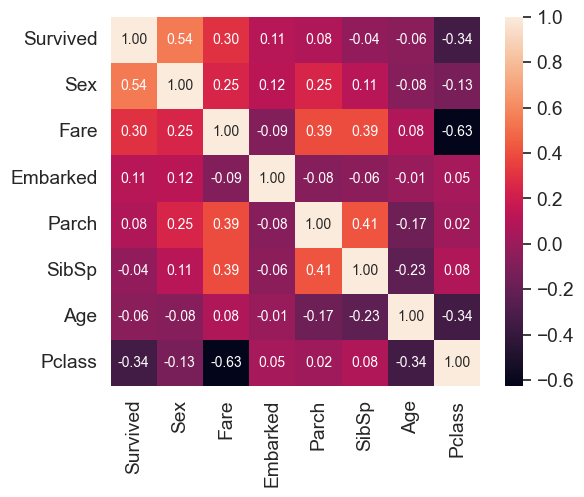

In [5]:
#Correlations
k  = 8
corrmat = train_df.corr()
cols = corrmat.nlargest(k, 'Survived')['Survived'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [6]:
#Modeling 
X_train = train_df.drop(["Survived"], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(["SibSp"], axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 6))

In [7]:
# For each X, calculate VIF and save in dataframe

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,3.8,Pclass
1,1.7,Sex
2,5.1,Age
3,1.8,SibSp
4,1.7,Parch
5,4.1,Fare
6,1.4,Embarked


In [8]:
#Feature selection using RFE
model = LogisticRegression()
rfe = RFE(model)
fit = rfe.fit(X_train, Y_train)
print("Num Features: ",fit.n_features_)
print("Selected Features: ",fit.support_)
print("Feature Ranking: ",fit.ranking_)
print(X_train.head())

Num Features:  3
Selected Features:  [ True  True False False False False  True]
Feature Ranking:  [1 1 5 2 4 3 1]
   Pclass  Sex   Age  SibSp  Parch  Fare  Embarked
0       3    0  22.0      1      0     0         0
1       1    1  38.0      1      0     3         1
2       3    1  26.0      0      0     1         0
3       1    1  35.0      1      0     3         0
4       3    0  35.0      0      0     1         0


In [9]:
#Feature selection using SelectKBest
Kbestscore = SelectKBest(score_func=chi2, k=4)
fit = Kbestscore.fit(X_train, Y_train)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_train)
# summarize selected features
print(features[0:5,:])
print (X_train.head())

[ 30.874 170.348  21.649   2.582  10.097  64.722  11.353]
[[ 3.  0. 22.  0.]
 [ 1.  1. 38.  3.]
 [ 3.  1. 26.  1.]
 [ 1.  1. 35.  3.]
 [ 3.  0. 35.  1.]]
   Pclass  Sex   Age  SibSp  Parch  Fare  Embarked
0       3    0  22.0      1      0     0         0
1       1    1  38.0      1      0     3         1
2       3    1  26.0      0      0     1         0
3       1    1  35.0      1      0     3         0
4       3    0  35.0      0      0     1         0


In [11]:
#Drop variables after feature selection:

X_train_df = train_df.drop(["Survived","SibSp","Parch","Embarked"], axis=1)
Y_train_df = train_df["Survived"]
X_test_df  = test_df.drop(["SibSp","Parch","Embarked"], axis=1)
X_train_df.shape, Y_train_df.shape, X_test_df.shape

((891, 4), (891,), (418, 4))

## Plotting the Decision Tree:

### 2. Learn and fine-tune a decision tree model with the Titanic training data, plot your decision tree (5 points )

[Text(0.4451499607252038, 0.9761904761904762, 'Sex <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = died'),
 Text(0.12811411981997284, 0.9285714285714286, 'Age <= 6.5\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = died'),
 Text(0.02309782608695652, 0.8809523809523809, 'SibSp <= 2.5\ngini = 0.444\nsamples = 24\nvalue = [8, 16]\nclass = survived'),
 Text(0.017663043478260868, 0.8333333333333334, 'gini = 0.0\nsamples = 15\nvalue = [0, 15]\nclass = survived'),
 Text(0.028532608695652172, 0.8333333333333334, 'Age <= 2.5\ngini = 0.198\nsamples = 9\nvalue = [8, 1]\nclass = died'),
 Text(0.02309782608695652, 0.7857142857142857, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]\nclass = died'),
 Text(0.033967391304347824, 0.7857142857142857, 'Age <= 3.5\ngini = 0.375\nsamples = 4\nvalue = [3, 1]\nclass = died'),
 Text(0.028532608695652172, 0.7380952380952381, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = survived'),
 Text(0.03940217391304348, 0.7380952380952381, 'gini = 0.

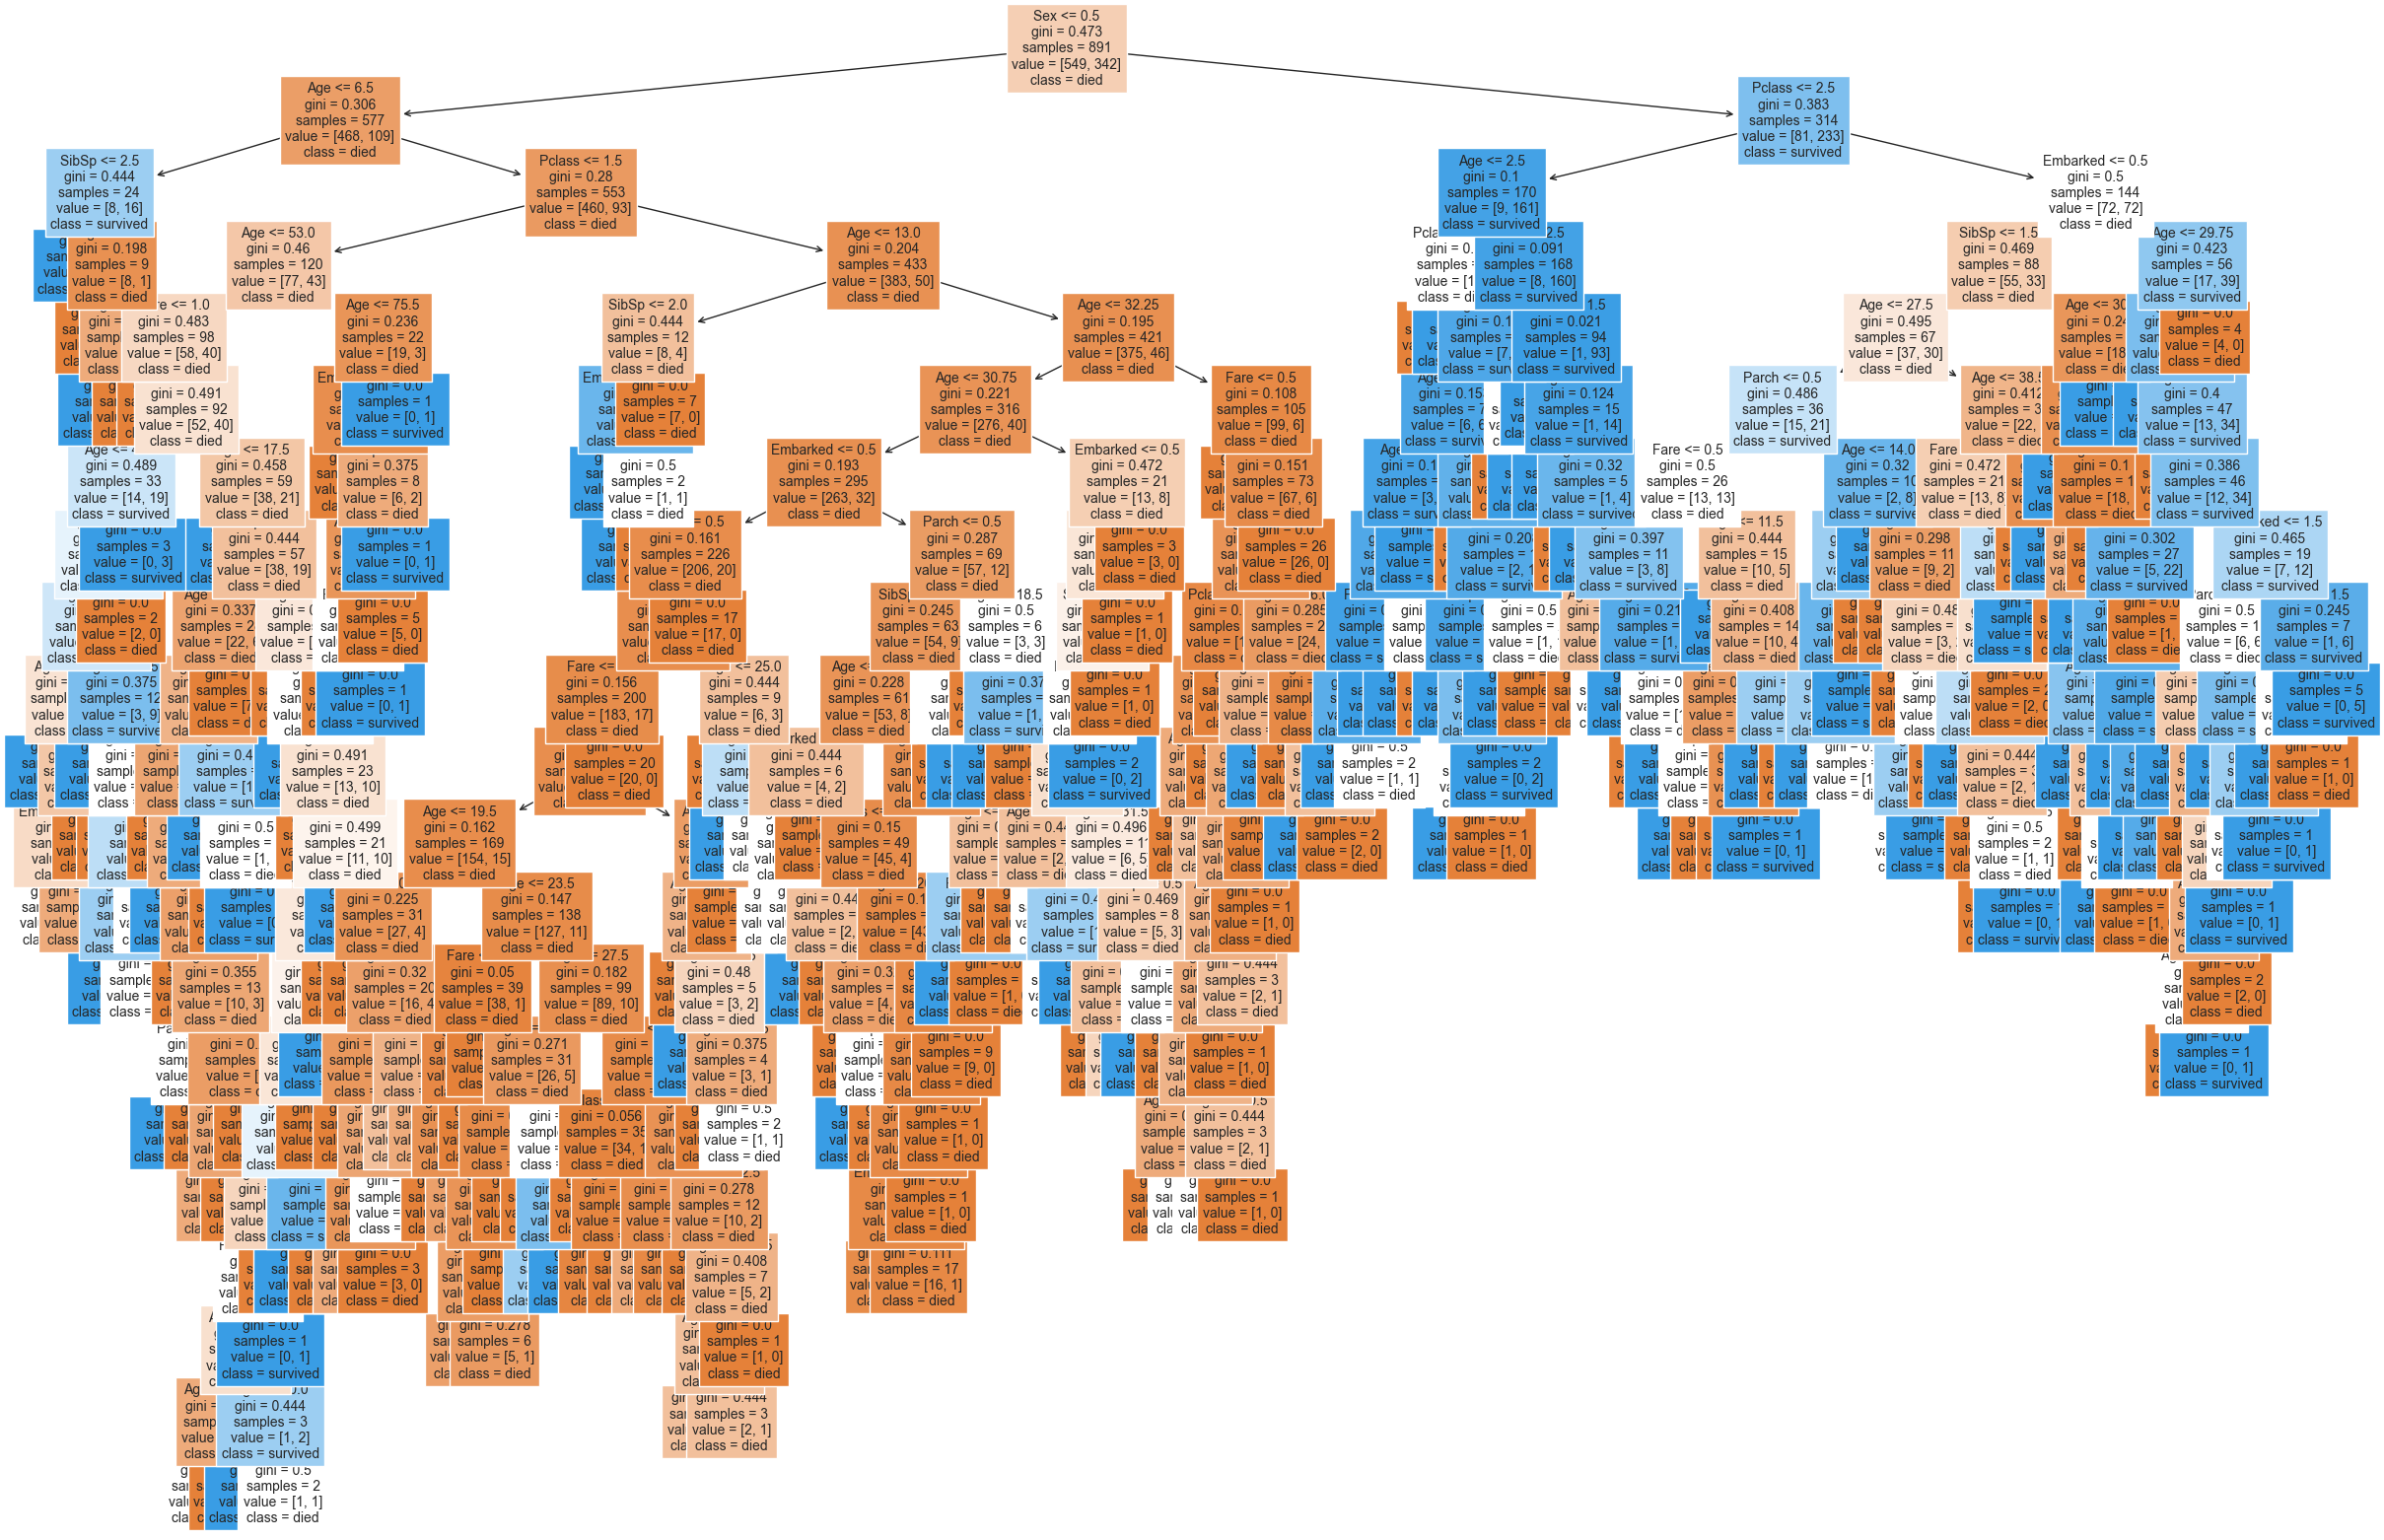

In [12]:
dt = DecisionTreeClassifier(criterion='gini',random_state = 42)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 
                       random_state=42, splitter='best')

plt.figure(figsize=(30,20))  
feature_names = list(X_train.columns)
class_names = ['died','survived']
tree.plot_tree(dt, fontsize=10, filled=True,feature_names=feature_names, class_names=class_names)

In [13]:
### Using Max Depth for defining depth of the Tree

decision_tree = DecisionTreeClassifier(criterion='gini',random_state = 42, max_depth=4)
clf = decision_tree.fit(X_train, Y_train)

feature_names = list(X_train.columns)

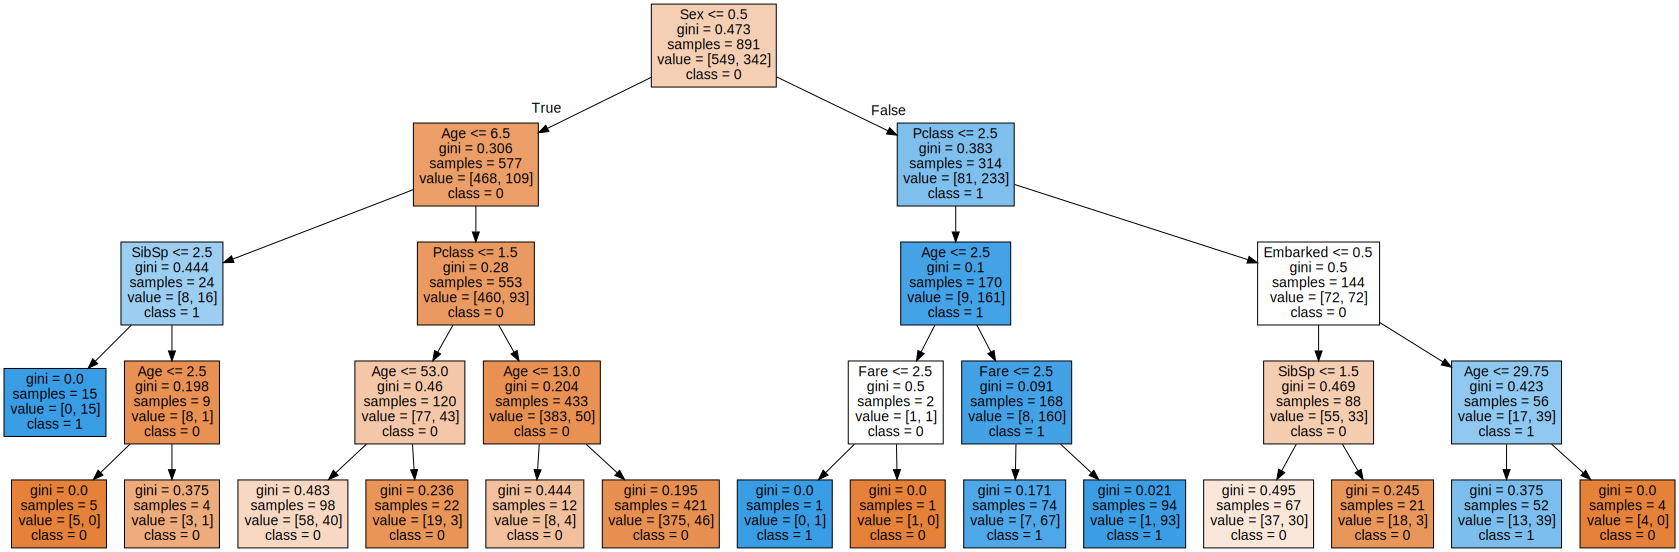

In [14]:
tree_data = tree.export_graphviz(decision_tree, out_file=None, 
                                feature_names=feature_names,  
                                class_names=['0','1'],
                                filled=True)

# Draw graph
graph = graphviz.Source(tree_data, format="png") 
graph

## 5-Fold Cross Validation:

### 3. Apply the five-fold cross validation of your fine-tuned decision tree learning model to the Titanic training data to extract average classification accuracy (5 points)

In [15]:
#Model - Decision tree using GIni index - accuracy and AUC; 

# Create Decision Tree classifer object
decision_tree = DecisionTreeClassifier(max_depth=4)
clf = decision_tree.fit(X_train, Y_train)
acc = cross_val_score(clf, X_train, Y_train, cv=5)
scores = cross_val_score(clf, X_train, Y_train, cv=5, scoring='roc_auc')

print("5K CV Decision tree classification accuracy:", acc)
print("5K CV Decision tree average classification accuracy: ", acc.mean())
print("=== Mean AUC Score ===")
print("Training Mean AUC Score - Decision tree: ", scores.mean())

5K CV Decision tree classification accuracy: [0.804 0.815 0.803 0.787 0.86 ]
5K CV Decision tree average classification accuracy:  0.8137028435126483
=== Mean AUC Score ===
Training Mean AUC Score - Decision tree:  0.8397871432360159


### 4. Apply the five-fold cross validation of your fine-tuned random forest learning model to the Titanic training data to extract average classification accuracy (5 points) 

In [16]:
#Model - random forest- accuracy and AUC; 

random_forest = RandomForestClassifier(n_estimators=400,random_state = 22)
rff = random_forest.fit(X_train, Y_train)
acc = cross_val_score(rff, X_train, Y_train, cv=5)
scores = cross_val_score(rff, X_train, Y_train, cv=5, scoring='roc_auc')

print("5K CV Random Forest classification accuracy:", acc)
print("5K CV Random Forest average classification accuracy: ", acc.mean())
print("=== Mean AUC Score ===")
print("Training Mean AUC Score - Random Forest: ", scores.mean())

5K CV Random Forest classification accuracy: [0.793 0.787 0.831 0.792 0.843]
5K CV Random Forest average classification accuracy:  0.8092210156299041
=== Mean AUC Score ===
Training Mean AUC Score - Random Forest:  0.845765939149348


### 5. Which algorithm is better, Decision Tree or Random Forest? What are your observations and conclusions from the algorithm comparison and analysis? (5 points)

In [21]:
#after variable selection F1

X = train_df.drop(columns=['Survived','SibSp','Parch','Embarked']).values
Y = train_df['Survived'].values
XX_train_df, XX_test, YY_train_df, YY_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

# Building Decision Tree
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 22)
dt.fit(XX_train_df, YY_train_df)
dt_pred_train_df = dt.predict(XX_train_df)

# Evaluation on train_dfing set
dt_pred_train_df = dt.predict(XX_train_df)
print('DT train_dfing Set Evaluation F1-Score=>',f1_score(YY_train_df,dt_pred_train_df))

# Evaluating on Test set
dt_pred_test = dt.predict(XX_test)
print('DT Validation Set Evaluation F1-Score=>',f1_score(YY_test,dt_pred_test))

# Building  Random Forest Classifier
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 22)
rfc.fit(XX_train_df, YY_train_df)

# Evaluating on train_dfing set
rfc_pred_train_df = rfc.predict(XX_train_df)
print('RF train_dfing Set Evaluation F1-Score=>',f1_score(YY_train_df,rfc_pred_train_df))

# Evaluating on Test set
rfc_pred_test = rfc.predict(XX_test)
print('RF Validation Set Evaluation F1-Score=>',f1_score(YY_test,rfc_pred_test))

DT train_dfing Set Evaluation F1-Score=> 0.8988326848249028
DT Validation Set Evaluation F1-Score=> 0.7299270072992701
RF train_dfing Set Evaluation F1-Score=> 0.9011406844106464
RF Validation Set Evaluation F1-Score=> 0.7375886524822696


***Obervations:***

- `Random forest is a bagging method by combining week classifers into a stronger prediction model and also de-correlated variables, thus reduce variance and overffiting. It generally has better performance than decision tree.`

## Task 6:

**Construct a support vector machine that computes the kernel function. Use four values of +1 and -1 for both inputs and outputs: (20 points)**

        [−1, −1] (negative)
        
        [−1, +1] (positive)
        
        [+1, −1] (positive)
        
        [+1, +1] (negative).

- Map the input [x1, x2] into a space consisting of x1 and x1x2. Draw the four input points in this space, and the maximal margin separator. What is the margin? 【 To be consistent with our lecture notes, margin is defined as the distance from the middle way/hyperplane to either support vectors. 】

Text(0.5, 1.0, 'Scatter plot of data to be classified')

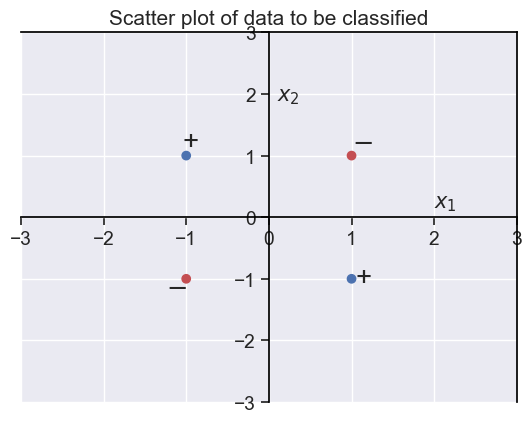

In [78]:
## Plotting data

x = np.array([[-1,-1],
              [-1,1],
              [1,-1],
              [1,1]])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)

ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes

ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Show ticks in the left and lower axes only

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.scatter(x[:,0],x[:,1],c=['r','b','b','r'])
plt.text(-1.2,-1.05,'_', fontsize=20)
plt.text(1.05,-1.1,'+', fontsize=20)
plt.text(1.05,1.3,'_', fontsize=20)
plt.text(-1.05,1.1,'+', fontsize=20)
plt.text(2,0.15,'$x_1$', fontsize=15)
plt.text(0.1,1.9,'$x_2$', fontsize=15)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('Scatter plot of data to be classified')

### Transforming input [x1, x2] into a space consisting of x1 and x1x2.

In [27]:
x1x2 = np.prod(x,axis=1)
x_new = np.array([x[:,0], x1x2]).T
x_new

array([[-1,  1],
       [-1, -1],
       [ 1, -1],
       [ 1,  1]])

Text(0.5, 1.0, 'Scatter plot of transformed data')

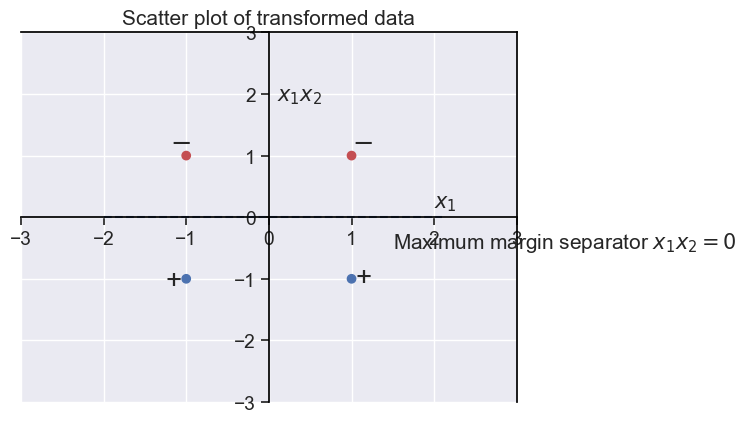

In [79]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
a = np.arange(-2,2.2,0.1)

plt.scatter(x_new[:,0],x_new[:,1],c=['r','b','b','r'])
plt.plot(a,np.zeros_like(a),'b--')
plt.text(-1.25,-1.15,'+', fontsize=20)
plt.text(1.05,-1.1,'+', fontsize=20)
plt.text(1.05,1.3,'_', fontsize=20)
plt.text(-1.15,1.3,'_', fontsize=20)
plt.text(1.5,-0.5,r'Maximum margin separator $x_1x_2 = 0$')
plt.text(2,0.15,'$x_1$', fontsize=15)
plt.text(0.1,1.9,'$x_1x_2$', fontsize=15)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('Scatter plot of transformed data')

    Note: In the above figure, the horizontal axis represents x1 and the vertical axis represents x1x2.

    From the figure above, we can see that after transforming the feature vectors from the space of (x1,x2) to (x1,x1x2), all the negative class points are above the x1 axis and all the positive class points are below the x1 axis. Thus, the data is now linearly seprable.

    Notice how the x1x2 = 0 hyperplane (it's a line in our case) separates the two classes with a maximum margin. This is shown by the blue dotted horizontal axis in the figure above. The points are now linearly separable in this new space  (x1,x1x2) by the maximum margin separator hyperplane x1x2 = 0  or by the lines x1 = 0 and x2 = 0 in the original space (x1,x2). 

***Computing the margin :***

- `Thus, x1x2 = -1 for the positive examples and x1x2 = + 1 for the negative examples. The line x1x2 = 0, with a margin of 1, serves as the maximum margin separator. In the original space, the separator corresponds to the axes at x1 = 0 and x2 = 0. This could be considered the limit of a separator with two hyperbolic branches.`


- `The margin can be easly computed by inspection because we know the support vectors and the maximum margin separator. From the above figure, we can see that the margin is 1 because the distance between the support vectors and the separating hyperplane is 1.`